# Blue Team: Anomaly and Out-of-Distribution (OOD) Detection

Author: Jessica Sihite<br>
Date: 28 September 2025<br>
See blue-team/README.md for detailed documentation.

**1. Set-up**

In [1]:
# Standard library imports
import os
import sys
import warnings
from pathlib import Path
from typing import Tuple, Dict, List, Optional, Union
import joblib

# Third-party imports
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import seaborn as sns
from torch.utils.data import DataLoader, TensorDataset

# Visualization imports
import matplotlib.pyplot as plt

# Machine learning imports
from sklearn.svm import OneClassSVM
from sklearn.neighbors import LocalOutlierFactor
from sklearn.metrics import (
    roc_auc_score, 
    roc_curve, 
    auc,
    confusion_matrix,
    classification_report,
    precision_recall_curve,
    average_precision_score,
    confusion_matrix,
    f1_score, 
    precision_score, 
    recall_score, 
    accuracy_score
)

# Settings
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Verify paths
PROJECT_PATH = Path("/Users/jessicalarissa/Documents/COMP90073-Assignment2")
DATA_DIR = PROJECT_PATH / 'data'
TEMPLATE_DIR = PROJECT_PATH / 'template_code'
RESULTS_DIR = PROJECT_PATH / 'results'

# Load pre-trained model using code from load.py
sys.path.append(str(TEMPLATE_DIR))
import model

# Device configuration
DEVICE = torch.device('cpu')
dtype = torch.float32
RANDOM_SEED = 42

# Download library from template code 'model.py'
weights = torch.load(DATA_DIR /'model_chkpt.pt', map_location=DEVICE)

pretrained_model = model.Averager(1, 10, 0.125)
pretrained_model.model.load_state_dict(weights)
pretrained_model.model.to(dtype)
pretrained_model.model.to(DEVICE)
pretrained_model.eval()

# Set random seeds
torch.manual_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

**2. Dataset Loading and Visualisation**


Anomaly Detection Validation Set - 'AD_val.pt'
Total samples: 2000
  Anomalies: 1000 (50.00%), Normal: 1000 (50.00%)

Out-of-Distribution Detection Validation Set - 'OOD_val.pt'
Total samples: 5000
  OOD: 2500 (50.00%), ID: 2500 (50.00%)

Anomaly Detection Test Set - 'AD_test.pt'
Total samples: 10000

Out-of-Distribution Detection Test Set - 'OOD_test.pt'
Total samples: 10000


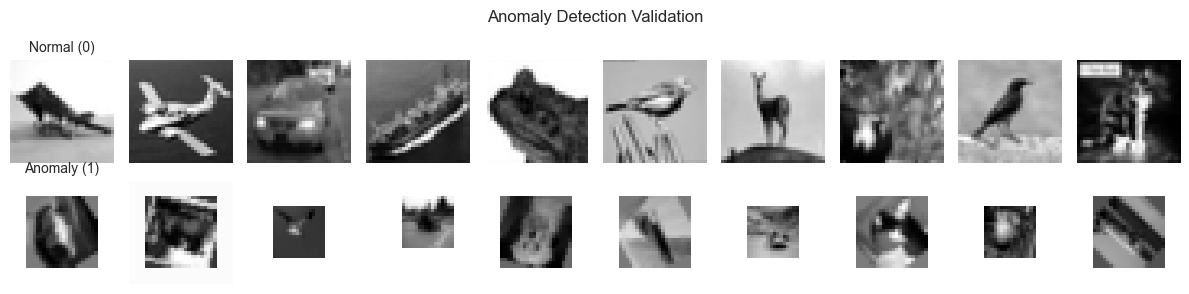

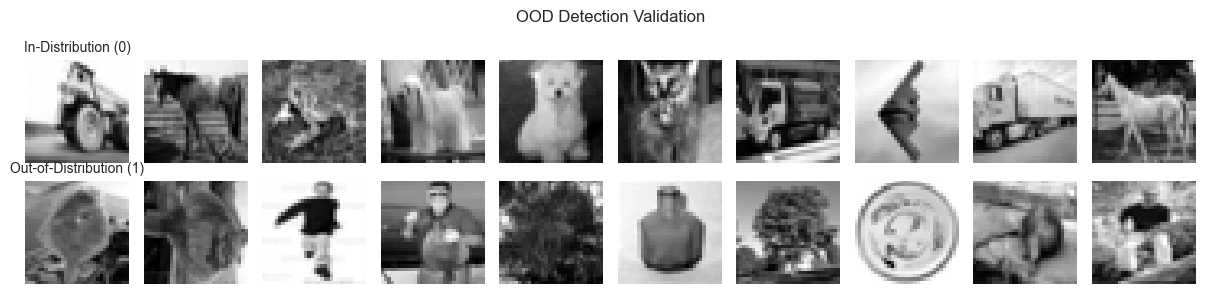

In [2]:
# Load all datasets into specific variables
# Validation sets
ad_val = torch.load(DATA_DIR / 'AD_val.pt', weights_only = False)
ood_val = torch.load(DATA_DIR / 'OOD_val.pt', weights_only = False)

# Test sets  
ad_test = torch.load(DATA_DIR / 'AD_test.pt', weights_only = False)
ood_test = torch.load(DATA_DIR / 'OOD_test.pt', weights_only = False)

# Normal dataset
normal_dataset = torch.load(DATA_DIR / "dataset.pt", weights_only = False)

# Define validation set to analyse
validation_sets = {
    'AD': (ad_val, 'Anomaly Detection', 'AD_val.pt'),
    'OOD': (ood_val, 'Out-of-Distribution Detection', 'OOD_val.pt')
}

# Iterate through both validation sets for statistics
for key, (val_data, task_name, filename) in validation_sets.items():
    print(f"\n{task_name} Validation Set - '{filename}'")
    
    # Get total count
    total_samples = len(val_data)
    
    # Get all targets
    _, targets = val_data[0:len(val_data)]
    
    # Count labels using sum()
    label_1_count = (targets == 1).sum().item()
    label_0_count = (targets == 0).sum().item()
    label_1_ratio = label_1_count/total_samples
    label_0_ratio = label_0_count/total_samples
    
    # Display results
    print(f"Total samples: {total_samples}")
    
    # Dataset-specific
    if key == 'AD':
        print(f"  Anomalies: {label_1_count} ({label_1_ratio:.2%}), Normal: {label_0_count} ({label_0_ratio:.2%})")
    else:  # OOD
        print(f"  OOD: {label_1_count} ({label_1_ratio:.2%}), ID: {label_0_count} ({label_0_ratio:.2%})")

# Define test sets to analyse
test_sets = {
    'AD': (ad_test, 'Anomaly Detection', 'AD_test.pt'),
    'OOD': (ood_test, 'Out-of-Distribution Detection', 'OOD_test.pt')
}

# Iterate through test sets
for key, (test_data, task_name, filename) in test_sets.items():
    print(f"\n{task_name} Test Set - '{filename}'")
    
    # Get total count
    total_samples = len(test_data)
    
    # Display results
    print(f"Total samples: {total_samples}")

def visualise_samples(data, targets, title, n_samples=8):
    """Visualise samples from a dataset split by labels"""
    
    # Get indices for each class
    label_0_indices = torch.where(targets == 0)[0][:n_samples]
    label_1_indices = torch.where(targets == 1)[0][:n_samples]
    
    # Create figure
    fig, axes = plt.subplots(2, n_samples, figsize=(12, 3))
    
    # Determine labels based on title
    if "Anomaly" in title:
        label_0_name, label_1_name = "Normal", "Anomaly"
    else:
        label_0_name, label_1_name = "In-Distribution", "Out-of-Distribution"
    
    # Plot label 0 samples
    for i, idx in enumerate(label_0_indices):
        img = data[idx].squeeze()
        axes[0, i].imshow(img, cmap='gray')
        axes[0, i].axis('off')
        if i == 0:
            axes[0, i].set_title(f'{label_0_name} (0)', fontsize=10)
    
    # Plot label 1 samples
    for i, idx in enumerate(label_1_indices):
        img = data[idx].squeeze()
        axes[1, i].imshow(img, cmap='gray')
        axes[1, i].axis('off')
        if i == 0:
            axes[1, i].set_title(f'{label_1_name} (1)', fontsize=10)
    
    plt.suptitle(title, fontsize=12)
    plt.tight_layout()
    plt.show()

# Visualize AD validation set
ad_data, ad_targets = ad_val[0:len(ad_val)]
visualise_samples(ad_data, ad_targets, "Anomaly Detection Validation", n_samples=10)

# Visualize OOD validation set  
ood_data, ood_targets = ood_val[0:len(ood_val)]
visualise_samples(ood_data, ood_targets, "OOD Detection Validation", n_samples=10)

## **Shallow Model for Anomaly Detection: OCSVM.**

Training features shape: (10000, 512)
Validation features shape: (2000, 512)
Best parameters: {'kernel': 'linear', 'nu': 0.1}
Best validation F1: 0.9235

Validation Performance:
  Accuracy:  0.9215
  F1-Score:  0.9235
  Precision: 0.9010
  Recall:    0.9470
  AUROC: 0.9692
  AUPRC: 0.9452


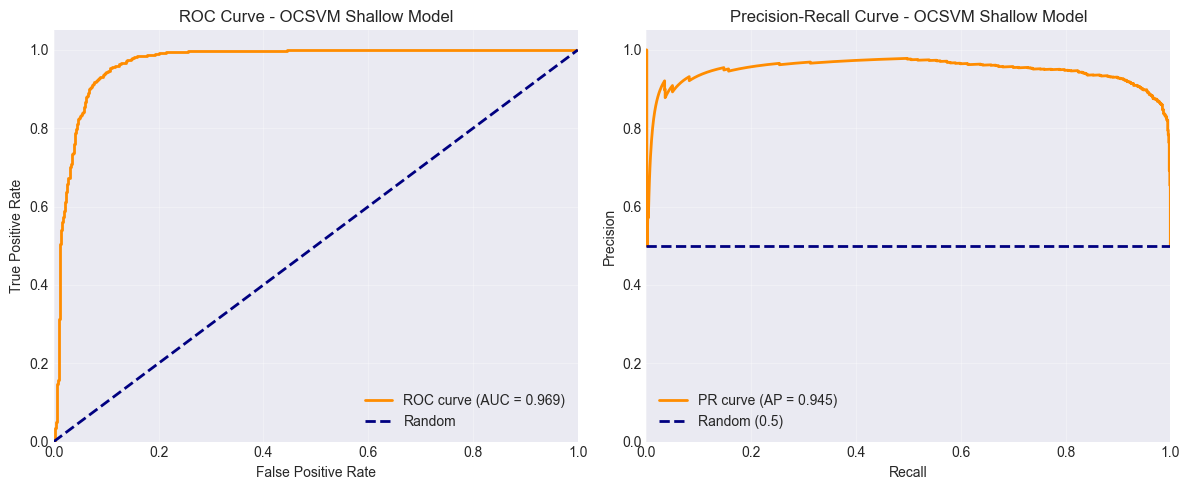

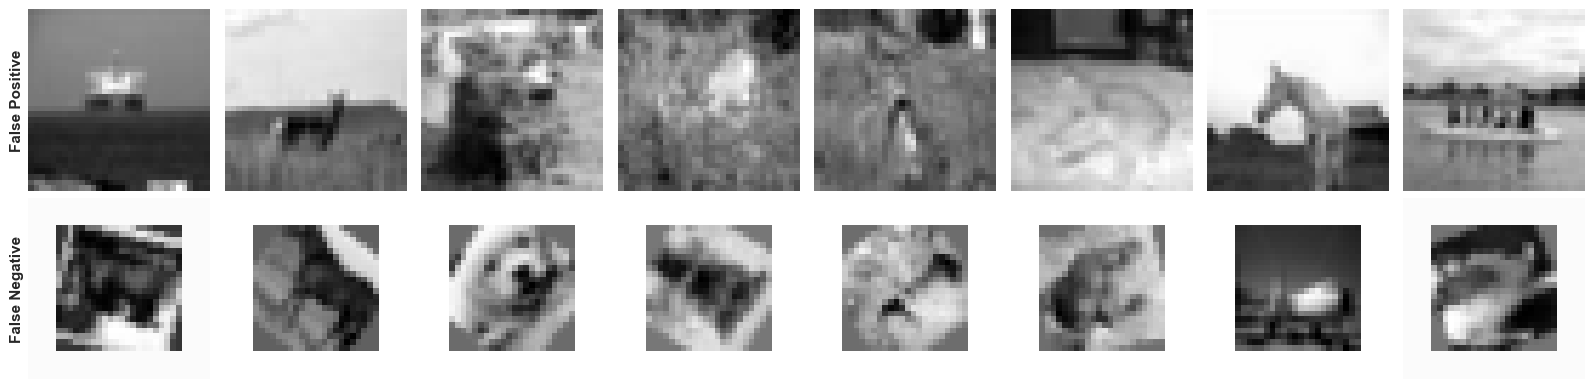


Error Analysis:
False Positives: 104 (10.40% of normal)
False Negatives: 53 (5.30% of anomalies)
Test data shape: torch.Size([10000, 1, 32, 32])
Predicted anomalies: 5240/10000


In [3]:
# Feature extraction function (512D from pooling layer)
def extract_deep_features(model, data, batch_size=256):
    """Extract 512D features from pooling layer"""
    features_list = []
    
    def forward_until_pool(x):
        x = model.model.conv1(x)      
        x = model.model.conv2(x)     
        x = model.model.conv3(x)
        x = x + model.model.conv5(model.model.conv4(x))
        x = model.model.conv6(x)
        x = model.model.conv7(x)
        x = x + model.model.conv9(model.model.conv8(x))
        x = model.model.pool10(x)
        return x.reshape(x.size(0), -1)
    
    with torch.no_grad():
        for i in range(0, len(data), batch_size):
            batch = data[i:i+batch_size].to(DEVICE)
            features = forward_until_pool(batch)
            features_list.append(features.cpu())
    
    return torch.cat(features_list, dim=0).numpy()

# Extract features from normal_dataset (training data)
train_data, train_labels = normal_dataset[0:len(normal_dataset)]
train_features = extract_deep_features(pretrained_model, train_data)
print(f"Training features shape: {train_features.shape}")

# Extract features from ad_val (validation set)
val_data, val_targets = ad_val[0:len(ad_val)]
val_features = extract_deep_features(pretrained_model, val_data)
print(f"Validation features shape: {val_features.shape}")

# Quick parameter tuning
nu_values = [0.01, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3]
kernel_options = ['linear', 'rbf']

best_params = None
best_f1 = 0

for kernel in kernel_options:
    for nu in nu_values:
        # Train on dataset.pt features
        ocsvm = OneClassSVM(kernel=kernel, nu=nu)
        ocsvm.fit(train_features)
        
        # Validate on AD_val.pt
        predictions = ocsvm.predict(val_features)
        predictions_binary = (predictions == -1).astype(int)
        
        # Calculate F1 score
        f1 = f1_score(val_targets.numpy(), predictions_binary)
        
        if f1 > best_f1:
            best_f1 = f1
            best_params = {'kernel': kernel, 'nu': nu}

print(f"Best parameters: {best_params}")
print(f"Best validation F1: {best_f1:.4f}")

# Train final model
ocsvm_final = OneClassSVM(**best_params)
ocsvm_final.fit(train_features)

# Evaluate on validation set
predictions_val = ocsvm_final.predict(val_features)
predictions_binary = (predictions_val == -1).astype(int)

# Calculate metrics
ocsvm_acc = accuracy_score(val_targets.numpy(), predictions_binary)
ocsvm_f1 = f1_score(val_targets.numpy(), predictions_binary)
ocsvm_prec = precision_score(val_targets.numpy(), predictions_binary)
ocsvm_rec = recall_score(val_targets.numpy(), predictions_binary)
decision_scores = ocsvm_final.decision_function(val_features)
anomaly_scores = -decision_scores  # More negative = more anomalous
ocsvm_auroc = roc_auc_score(ad_targets.numpy(), anomaly_scores)
ocsvm_auprc = average_precision_score(ad_targets.numpy(), anomaly_scores)

print(f"\nValidation Performance:")
print(f"  Accuracy:  {ocsvm_acc:.4f}")
print(f"  F1-Score:  {ocsvm_f1:.4f}")
print(f"  Precision: {ocsvm_prec:.4f}")
print(f"  Recall:    {ocsvm_rec:.4f}")
print(f"  AUROC: {ocsvm_auroc:.4f}")
print(f"  AUPRC: {ocsvm_auprc:.4f}")

# Plot ROC and PR curves
fpr, tpr, _ = roc_curve(val_targets.numpy(), anomaly_scores)
precision_vals, recall_vals, _ = precision_recall_curve(val_targets.numpy(), anomaly_scores)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# ROC Curve
ax1.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {ocsvm_auroc:.3f})')
ax1.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')
ax1.set_xlim([0.0, 1.0])
ax1.set_ylim([0.0, 1.05])
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.set_title('ROC Curve - OCSVM Shallow Model')
ax1.legend(loc="lower right")
ax1.grid(True, alpha=0.3)

# Precision-Recall Curve
ax2.plot(recall_vals, precision_vals, color='darkorange', lw=2, label=f'PR curve (AP = {ocsvm_auprc:.3f})')
ax2.axhline(y=0.5, color='navy', lw=2, linestyle='--', label='Random (0.5)')
ax2.set_xlim([0.0, 1.0])
ax2.set_ylim([0.0, 1.05])
ax2.set_xlabel('Recall')
ax2.set_ylabel('Precision')
ax2.set_title('Precision-Recall Curve - OCSVM Shallow Model')
ax2.legend(loc="lower left")
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Visualize False Positives and False Negatives
fp_mask = (predictions_binary == 1) & (val_targets.numpy() == 0)
fn_mask = (predictions_binary == 0) & (val_targets.numpy() == 1)

fp_indices = np.where(fp_mask)[0]
fn_indices = np.where(fn_mask)[0]

n_display = 8
fig, axes = plt.subplots(2, n_display, figsize=(16, 4))

for i in range(min(n_display, len(fp_indices))):
    axes[0, i].imshow(val_data[fp_indices[i]].squeeze(), cmap='gray')
    axes[0, i].axis('off')

for i in range(min(n_display, len(fn_indices))):
    axes[1, i].imshow(val_data[fn_indices[i]].squeeze(), cmap='gray')
    axes[1, i].axis('off')

axes[0, 0].text(-0.1, 0.5, 'False Positive', transform=axes[0, 0].transAxes, 
                rotation=90, va='center', fontsize=11, weight='bold')
axes[1, 0].text(-0.1, 0.5, 'False Negative', transform=axes[1, 0].transAxes, 
                rotation=90, va='center', fontsize=11, weight='bold')

plt.tight_layout()
plt.savefig('ocsvm_error_examples.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\nError Analysis:")
print(f"False Positives: {fp_mask.sum()} ({100*fp_mask.sum()/(val_targets==0).sum().item():.2f}% of normal)")
print(f"False Negatives: {fn_mask.sum()} ({100*fn_mask.sum()/(val_targets==1).sum().item():.2f}% of anomalies)")

# Apply to test set
# Test set returns tuple with single element (just data, no targets)
ad_test_data, = ad_test[0:len(ad_test)]  # Unpack single element from tuple
print(f"Test data shape: {ad_test_data.shape}")

# Extract features from test set
test_features = extract_deep_features(pretrained_model, ad_test_data)

# Predict
test_predictions = ocsvm_final.predict(test_features)
test_predictions_binary = (test_predictions == -1).astype(int)
print(f"Predicted anomalies: {test_predictions_binary.sum()}/{len(test_predictions_binary)}")

# Save predictions to 1.pt
RESULTS_DIR.mkdir(exist_ok=True)
test_predictions_tensor = torch.tensor(test_predictions_binary)
output_dataset = TensorDataset(ad_test_data, test_predictions_tensor)
torch.save(output_dataset, RESULTS_DIR / '1.pt')

## Post-hoc analysis and visualisation of OCSVM test predictions.

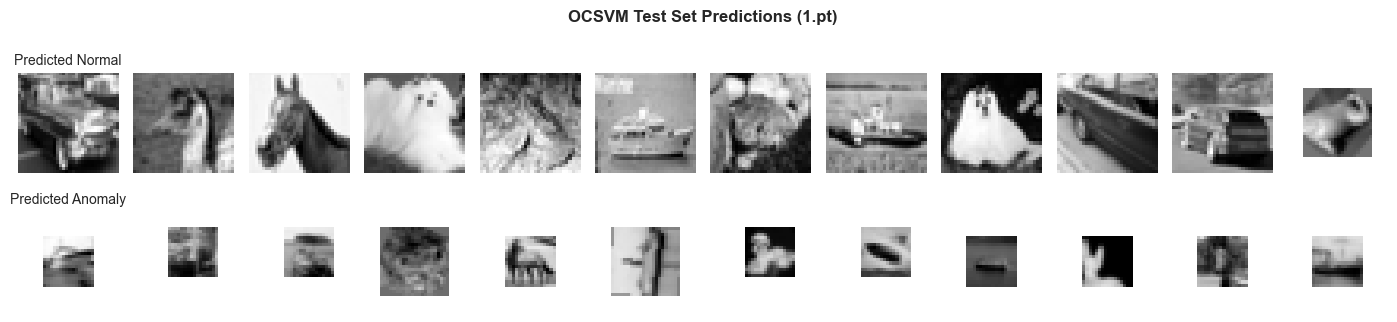

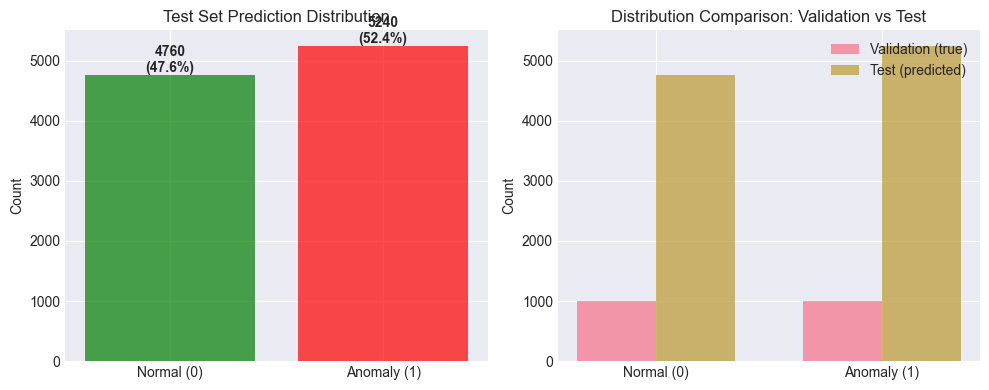

Prediction Statistics:
Predicted Normal: 4760 (47.6%)
Predicted Anomaly: 5240 (52.4%)


In [4]:
# Load test predictions
predictions_1pt = torch.load(RESULTS_DIR / '1.pt', weights_only = False)
test_data_loaded, predictions_1pt = predictions_1pt[0:len(predictions_1pt)]

# Get test data
ad_test_data, = ad_test[0:len(ad_test)]

# Visualize samples predicted as normal vs anomaly
def visualize_test_predictions(data, predictions, n_samples=10):
    """Visualize test samples split by predicted labels"""
    
    # Get indices for each predicted class
    normal_indices = torch.where(predictions == 0)[0][:n_samples]
    anomaly_indices = torch.where(predictions == 1)[0][:n_samples]
    
    # Create figure
    fig, axes = plt.subplots(2, n_samples, figsize=(14, 3.5))
    
    # Plot predicted normal samples
    for i, idx in enumerate(normal_indices):
        img = data[idx].squeeze()
        axes[0, i].imshow(img, cmap='gray')
        axes[0, i].axis('off')
        if i == 0:
            axes[0, i].set_title('Predicted Normal', fontsize=10)
    
    # Plot predicted anomaly samples
    for i, idx in enumerate(anomaly_indices):
        img = data[idx].squeeze()
        axes[1, i].imshow(img, cmap='gray')
        axes[1, i].axis('off')
        if i == 0:
            axes[1, i].set_title('Predicted Anomaly', fontsize=10)
    
    plt.suptitle('OCSVM Test Set Predictions (1.pt)', fontsize=12, fontweight='bold')
    plt.tight_layout()
    plt.show()

# Visualize predictions
visualize_test_predictions(ad_test_data, predictions_1pt, n_samples=12)

# Show prediction distribution
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

# Bar chart of predictions
labels = ['Normal (0)', 'Anomaly (1)']
counts = [(predictions_1pt == 0).sum().item(), (predictions_1pt == 1).sum().item()]
colors = ['green', 'red']

ax1.bar(labels, counts, color=colors, alpha=0.7)
ax1.set_ylabel('Count')
ax1.set_title('Test Set Prediction Distribution')
for i, v in enumerate(counts):
    ax1.text(i, v + 50, f'{v}\n({v/len(predictions_1pt):.1%})', 
             ha='center', fontweight='bold')

# Compare with validation distribution
val_data, val_targets = ad_val[0:len(ad_val)]
val_counts = [(val_targets == 0).sum().item(), (val_targets == 1).sum().item()]
test_counts = counts

x = np.arange(len(labels))
width = 0.35

ax2.bar(x - width/2, val_counts, width, label='Validation (true)', alpha=0.7)
ax2.bar(x + width/2, test_counts, width, label='Test (predicted)', alpha=0.7)
ax2.set_ylabel('Count')
ax2.set_title('Distribution Comparison: Validation vs Test')
ax2.set_xticks(x)
ax2.set_xticklabels(labels)
ax2.legend()

plt.tight_layout()
plt.show()

print("Prediction Statistics:")
print(f"Predicted Normal: {counts[0]} ({counts[0]/len(predictions_1pt):.1%})")
print(f"Predicted Anomaly: {counts[1]} ({counts[1]/len(predictions_1pt):.1%})")

## Alternative model for comparative analysis: LOF.

Best LOF parameters: {'n_neighbors': 5, 'contamination': 0.3}
Best validation F1: 0.3524

LOF Validation Performance:
  Accuracy:  0.5240
  F1-Score:  0.3524
  Precision: 0.5511
  Recall:    0.2590
  AUROC: 0.5564
  AUPRC: 0.5348
Metric            OCSVM        LOF     Better
---------------------------------------------
Accuracy         0.9215     0.5240      OCSVM
F1-Score         0.9235     0.3524      OCSVM
Precision        0.9010     0.5511      OCSVM
Recall           0.9470     0.2590      OCSVM
AUROC            0.9692     0.5564      OCSVM
AUPRC            0.9452     0.5348      OCSVM

OCSVM performs 47.2% better on average


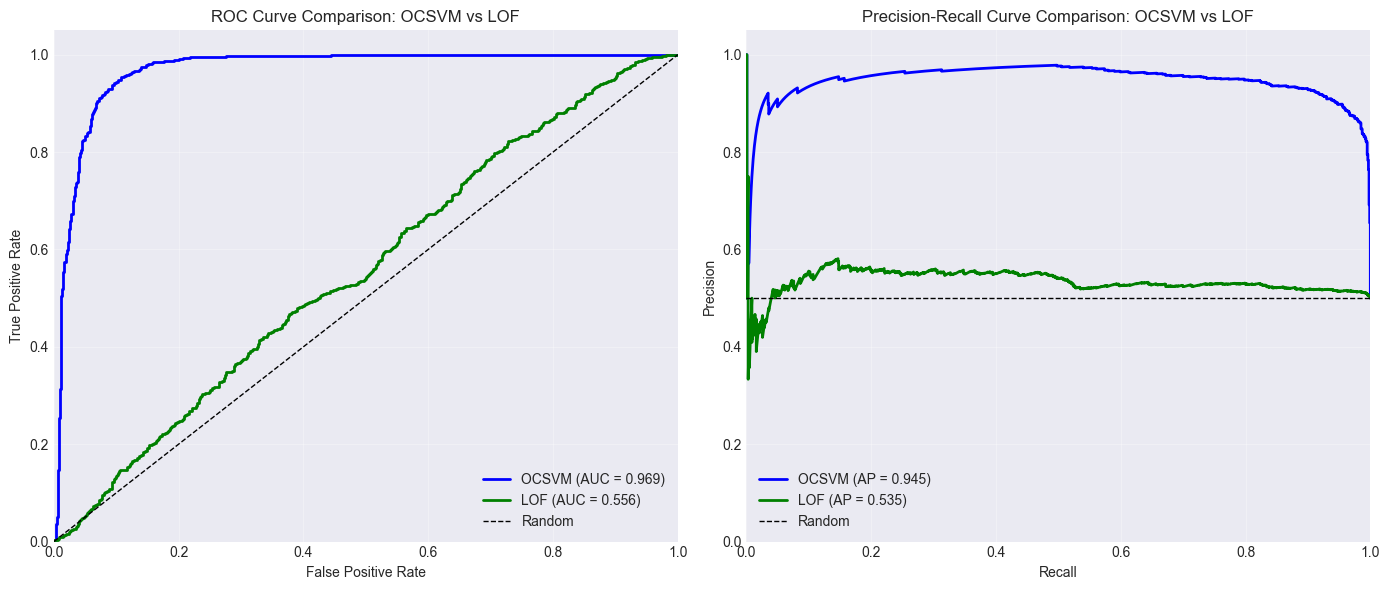

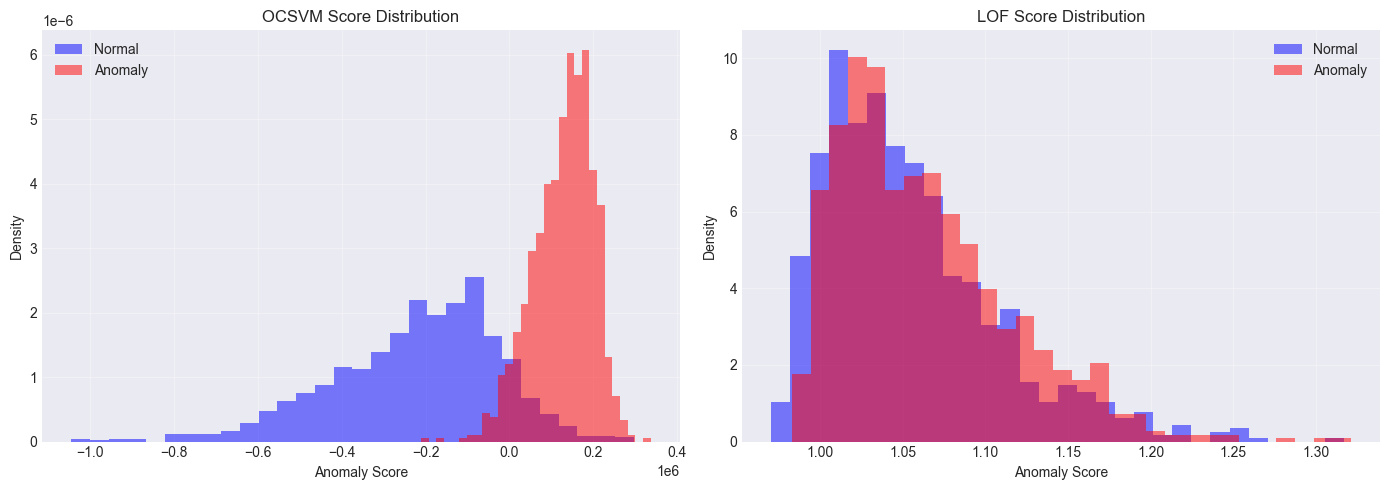


OCSVM shows superior performance:
  - F1-Score: 0.9235 (OCSVM) vs 0.3524 (LOF)
  - AUROC: 0.9692 (OCSVM) vs 0.5564 (LOF)


In [5]:
# Parameter tuning for LOF
n_neighbors_values = [5, 10, 20, 30, 50]
contamination_values = [0.1, 0.15, 0.2, 0.25, 0.3] # Model is trained on dataset.pt which consists of normal samples.
best_lof_params = None
best_lof_f1 = 0

for n_neighbors in n_neighbors_values:
    for contamination in contamination_values:
        lof = LocalOutlierFactor(
            n_neighbors=n_neighbors,
            contamination=contamination,
            novelty=True  # Important: allows predict on new data
        )
        lof.fit(train_features) # Using the same training data 
        
        # Predict on validation
        predictions_lof = lof.predict(val_features)
        predictions_lof_binary = (predictions_lof == -1).astype(int)
        
        f1 = f1_score(ad_targets.numpy(), predictions_lof_binary)
        
        if f1 > best_lof_f1:
            best_lof_f1 = f1
            best_lof_params = {
                'n_neighbors': n_neighbors,
                'contamination': contamination
            }

print(f"Best LOF parameters: {best_lof_params}")
print(f"Best validation F1: {best_lof_f1:.4f}")

# Train final LOF model with best parameters
lof_final = LocalOutlierFactor(
    n_neighbors=best_lof_params['n_neighbors'],
    contamination=best_lof_params['contamination'],
    novelty=True
)
lof_final.fit(train_features)

# Validate on validation set
predictions_lof = lof_final.predict(val_features)
predictions_lof_binary = (predictions_lof == -1).astype(int)

# Calculate evaluation metrics
lof_acc = accuracy_score(ad_targets.numpy(), predictions_lof_binary)
lof_f1 = f1_score(ad_targets.numpy(), predictions_lof_binary)
lof_prec = precision_score(ad_targets.numpy(), predictions_lof_binary)
lof_rec = recall_score(ad_targets.numpy(), predictions_lof_binary)
lof_scores = -lof_final.score_samples(val_features)  # Higher = more anomalous
lof_auroc = roc_auc_score(ad_targets.numpy(), lof_scores)
lof_auprc = average_precision_score(ad_targets.numpy(), lof_scores)

print(f"\nLOF Validation Performance:")
print(f"  Accuracy:  {lof_acc:.4f}")
print(f"  F1-Score:  {lof_f1:.4f}")
print(f"  Precision: {lof_prec:.4f}")
print(f"  Recall:    {lof_rec:.4f}")
print(f"  AUROC: {lof_auroc:.4f}")
print(f"  AUPRC: {lof_auprc:.4f}")

# Comparison: OCSVM vs LOF
# Use OCSVM results
comparison_data = {
    'Metric': ['Accuracy', 'F1-Score', 'Precision', 'Recall', 'AUROC', 'AUPRC'],
    'OCSVM': [ocsvm_acc, ocsvm_f1, ocsvm_prec, ocsvm_rec, ocsvm_auroc, ocsvm_auprc],
    'LOF': [lof_acc, lof_f1, lof_prec, lof_rec, lof_auroc, lof_auprc]
}

# Print comparison table
print(f"{'Metric':<12} {'OCSVM':>10} {'LOF':>10} {'Better':>10}")
print("-" * 45)
for i, metric in enumerate(comparison_data['Metric']):
    ocsvm_val = comparison_data['OCSVM'][i]
    lof_val = comparison_data['LOF'][i]
    better = 'OCSVM' if ocsvm_val > lof_val else 'LOF'
    print(f"{metric:<12} {ocsvm_val:>10.4f} {lof_val:>10.4f} {better:>10}")

# Calculate average improvement
avg_improvement = np.mean([(comparison_data['OCSVM'][i] - comparison_data['LOF'][i]) 
                           for i in range(len(comparison_data['Metric']))])
if avg_improvement > 0:
    print(f"\nOCSVM performs {avg_improvement:.1%} better on average")
else:
    print(f"\nLOF performs {-avg_improvement:.1%} better on average")

# Visualisation: AUROC and AUPRC curves
# Calculate curves for both models using variables from previous cells
fpr_ocsvm, tpr_ocsvm, _ = roc_curve(ad_targets.numpy(), anomaly_scores)  # anomaly_scores from OCSVM cell
fpr_lof, tpr_lof, _ = roc_curve(ad_targets.numpy(), lof_scores)

prec_ocsvm, rec_ocsvm, _ = precision_recall_curve(ad_targets.numpy(), anomaly_scores)
prec_lof, rec_lof, _ = precision_recall_curve(ad_targets.numpy(), lof_scores)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# ROC Curves Comparison
ax1.plot(fpr_ocsvm, tpr_ocsvm, lw=2, label=f'OCSVM (AUC = {ocsvm_auroc:.3f})', color='blue')
ax1.plot(fpr_lof, tpr_lof, lw=2, label=f'LOF (AUC = {lof_auroc:.3f})', color='green')
ax1.plot([0, 1], [0, 1], 'k--', lw=1, label='Random')
ax1.set_xlim([0.0, 1.0])
ax1.set_ylim([0.0, 1.05])
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.set_title('ROC Curve Comparison: OCSVM vs LOF')
ax1.legend(loc="lower right")
ax1.grid(True, alpha=0.3)

# PR Curves Comparison
ax2.plot(rec_ocsvm, prec_ocsvm, lw=2, label=f'OCSVM (AP = {ocsvm_auprc:.3f})', color='blue')
ax2.plot(rec_lof, prec_lof, lw=2, label=f'LOF (AP = {lof_auprc:.3f})', color='green')
ax2.axhline(y=0.5, color='k', lw=1, linestyle='--', label='Random')
ax2.set_xlim([0.0, 1.0])
ax2.set_ylim([0.0, 1.05])
ax2.set_xlabel('Recall')
ax2.set_ylabel('Precision')
ax2.set_title('Precision-Recall Curve Comparison: OCSVM vs LOF')
ax2.legend(loc="lower left")
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# OCSVM scores
normal_scores_ocsvm = anomaly_scores[ad_targets.numpy() == 0]
anomaly_scores_ocsvm = anomaly_scores[ad_targets.numpy() == 1]

ax1.hist(normal_scores_ocsvm, bins=30, alpha=0.5, label='Normal', color='blue', density=True)
ax1.hist(anomaly_scores_ocsvm, bins=30, alpha=0.5, label='Anomaly', color='red', density=True)
ax1.set_xlabel('Anomaly Score')
ax1.set_ylabel('Density')
ax1.set_title('OCSVM Score Distribution')
ax1.legend()
ax1.grid(True, alpha=0.3)

# LOF scores
normal_scores_lof = lof_scores[ad_targets.numpy() == 0]
anomaly_scores_lof = lof_scores[ad_targets.numpy() == 1]

ax2.hist(normal_scores_lof, bins=30, alpha=0.5, label='Normal', color='blue', density=True)
ax2.hist(anomaly_scores_lof, bins=30, alpha=0.5, label='Anomaly', color='red', density=True)
ax2.set_xlabel('Anomaly Score')
ax2.set_ylabel('Density')
ax2.set_title('LOF Score Distribution')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

if ocsvm_f1 > lof_f1:
    print(f"\nOCSVM shows superior performance:")
    print(f"  - F1-Score: {ocsvm_f1:.4f} (OCSVM) vs {lof_f1:.4f} (LOF)")
    print(f"  - AUROC: {ocsvm_auroc:.4f} (OCSVM) vs {lof_auroc:.4f} (LOF)")
else:
    print(f"\nLOF shows competitive performance:")
    print(f"  - F1-Score: {lof_f1:.4f} (LOF) vs {ocsvm_f1:.4f} (OCSVM)")
    print(f"  - AUROC: {lof_auroc:.4f} (LOF) vs {ocsvm_auroc:.4f} (OCSVM)")

## **Deep learning model for anomaly detection: Variational Autoencoder**.

Training samples: 10000 from dataset.pt
Epoch 10: Loss=0.5796, Recon=0.5768, KL=2.7673
Epoch 20: Loss=0.5780, Recon=0.5753, KL=2.6642
Epoch 30: Loss=0.5780, Recon=0.5754, KL=2.6496
Epoch 40: Loss=0.5774, Recon=0.5747, KL=2.6433
Epoch 50: Loss=0.5769, Recon=0.5743, KL=2.6418
Normal scores - Mean: 0.452352, Std: 0.057266
Anomaly scores - Mean: 0.584882, Std: 0.037397
Separation: 2.31 std

Threshold optimization:
  60%: F1=0.833, Predicted anomaly rate=70.0%
  65%: F1=0.851, Predicted anomaly rate=67.5%
  70%: F1=0.870, Predicted anomaly rate=65.0%
  75%: F1=0.889, Predicted anomaly rate=62.5%
  80%: F1=0.909, Predicted anomaly rate=60.0%
  85%: F1=0.930, Predicted anomaly rate=57.5%
  90%: F1=0.944, Predicted anomaly rate=54.2%
  95%: F1=0.828, Predicted anomaly rate=39.6%
  99%: F1=0.211, Predicted anomaly rate=6.5%

Best threshold: 0.524769 (percentile 90%)

Validation Performance:
  Accuracy:  0.9420
  F1-Score:  0.9443
  Precision: 0.9077
  Recall:    0.9840
  AUROC:     0.9632
  AUP

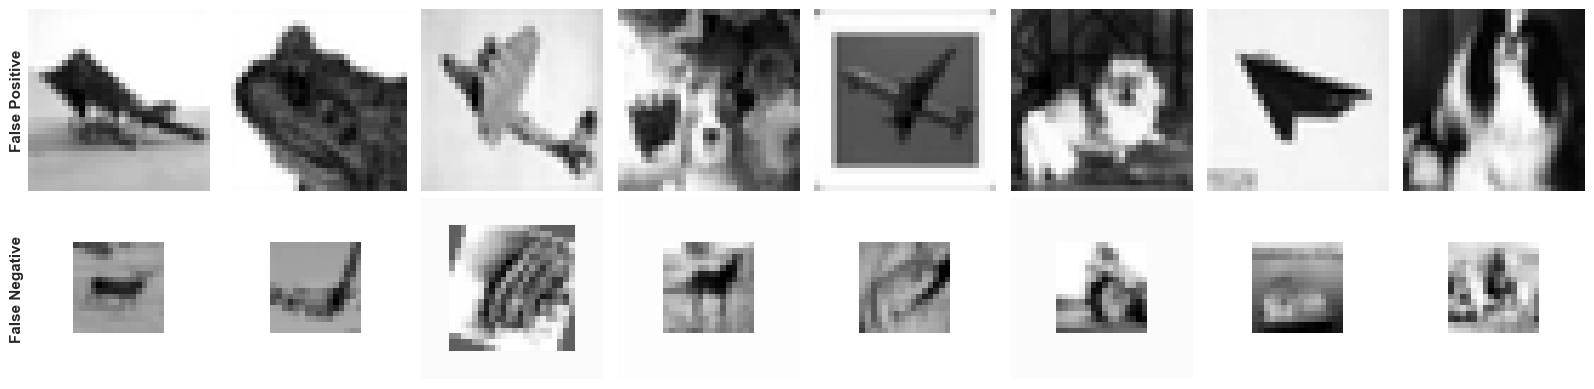


VAE Error Analysis:
False Positives: 100 (10.00% of normal)
False Negatives: 16 (1.60% of anomalies)
Test set predictions
Predicted anomalies: 5433/10000 (54.3%)


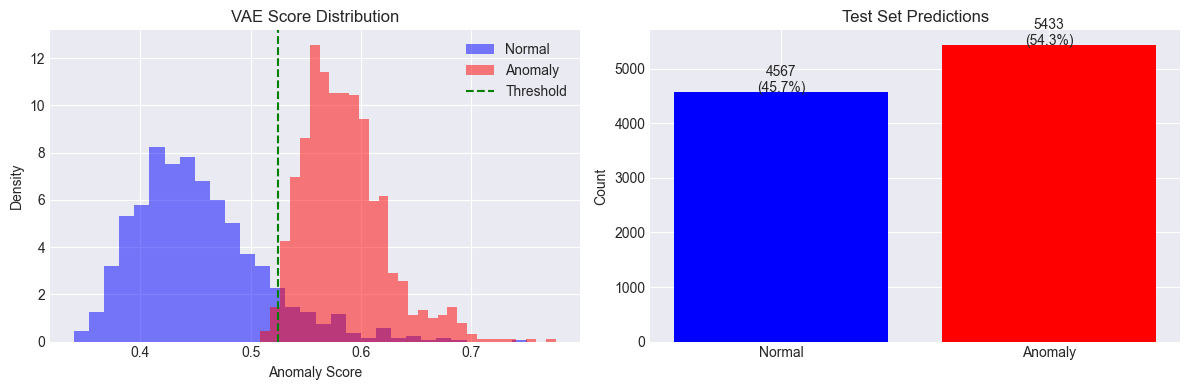

In [6]:
class VAE(nn.Module):
    def __init__(self, input_dim=1024, latent_dim=16):
        super().__init__()
        
        # Encoder
        self.fc1 = nn.Linear(input_dim, 256)
        self.bn1 = nn.BatchNorm1d(256)
        self.fc_mu = nn.Linear(256, latent_dim)
        self.fc_logvar = nn.Linear(256, latent_dim)
        
        # Decoder
        self.fc3 = nn.Linear(latent_dim, 256)
        self.bn3 = nn.BatchNorm1d(256)
        self.fc4 = nn.Linear(256, input_dim)
        
    def encode(self, x):
        h = torch.relu(self.bn1(self.fc1(x)))
        return self.fc_mu(h), self.fc_logvar(h)
    
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def decode(self, z):
        h = torch.relu(self.bn3(self.fc3(z)))
        return torch.sigmoid(self.fc4(h))
    
    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        recon = self.decode(z)
        return recon, mu, logvar

def vae_loss(recon_x, x, mu, logvar, beta=0.001):
    # Reconstruction loss
    BCE = nn.functional.binary_cross_entropy(recon_x, x, reduction='mean')
    # KL divergence
    KLD = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + beta * KLD, BCE, KLD

# 1. Train model
# Load and prepare training data
train_data, train_labels = normal_dataset[0:len(normal_dataset)]
train_data_flat = train_data.view(train_data.size(0), -1).float()

# Normalise training data
train_data_normalized = []
for i in range(len(train_data_flat)):
    sample = train_data_flat[i]
    sample_norm = (sample - sample.min()) / (sample.max() - sample.min() + 1e-8)
    train_data_normalized.append(sample_norm)
train_data_flat = torch.stack(train_data_normalized)

# Create DataLoader
train_dataset = TensorDataset(train_data_flat)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)

print(f"Training samples: {len(train_data_flat)} from dataset.pt")

# Initialize VAE
vae = VAE(input_dim=1024, latent_dim=16).to(DEVICE)
optimizer = optim.Adam(vae.parameters(), lr=0.001)

# Training loop
num_epochs = 50
beta = 0.001  # Low beta focuses on reconstruction

for epoch in range(num_epochs):
    vae.train()
    train_loss = 0
    recon_loss = 0
    kl_loss = 0
    
    for batch_data in train_loader:
        data = batch_data[0].to(DEVICE)
        
        # Forward pass
        recon_batch, mu, logvar = vae(data)
        loss, bce, kld = vae_loss(recon_batch, data, mu, logvar, beta)
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        recon_loss += bce.item()
        kl_loss += kld.item()
    
    if (epoch + 1) % 10 == 0:
        avg_loss = train_loss / len(train_loader)
        avg_recon = recon_loss / len(train_loader)
        avg_kl = kl_loss / len(train_loader)
        print(f'Epoch {epoch+1}: Loss={avg_loss:.4f}, Recon={avg_recon:.4f}, KL={avg_kl:.4f}')

# 2. Validation
# Load validation data
val_data, val_targets = ad_val[0:len(ad_val)]
val_data_flat = val_data.view(val_data.size(0), -1).float()

# Normalize validation data
val_data_normalized = []
for i in range(len(val_data_flat)):
    sample = val_data_flat[i]
    sample_norm = (sample - sample.min()) / (sample.max() - sample.min() + 1e-8)
    val_data_normalized.append(sample_norm)
val_data_flat = torch.stack(val_data_normalized)

# Calculate anomaly scores on validation set
vae.eval()
val_scores = []

with torch.no_grad():
    for i in range(0, len(val_data_flat), 128):
        batch = val_data_flat[i:i+128].to(DEVICE)
        recon, mu, logvar = vae(batch)
        
        # Reconstruction error
        recon_error = torch.mean((batch - recon) ** 2, dim=1)
        
        # KL divergence
        kl_div = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp(), dim=1)
        
        # Combined score
        anomaly_score = recon_error + 0.01 * kl_div
        val_scores.extend(anomaly_score.cpu().numpy())

val_scores = np.array(val_scores)

# Analyze error distributions
normal_mask = (val_targets == 0)
normal_scores = val_scores[normal_mask]
anomaly_scores = val_scores[~normal_mask]

print(f"Normal scores - Mean: {normal_scores.mean():.6f}, Std: {normal_scores.std():.6f}")
print(f"Anomaly scores - Mean: {anomaly_scores.mean():.6f}, Std: {anomaly_scores.std():.6f}")
print(f"Separation: {(anomaly_scores.mean() - normal_scores.mean())/normal_scores.std():.2f} std")

# Test multiple thresholds (including lower percentiles)
percentiles = [60, 65, 70, 75, 80, 85, 90, 95, 99]
best_f1 = 0
best_threshold = 0
best_percentile = 0

print("\nThreshold optimization:")
for p in percentiles:
    threshold = np.percentile(normal_scores, p)
    predictions = (val_scores > threshold).astype(int)
    f1 = f1_score(val_targets.numpy(), predictions)
    pred_rate = predictions.mean()
    
    if f1 > best_f1:
        best_f1 = f1
        best_threshold = threshold
        best_percentile = p
    
    print(f"  {p}%: F1={f1:.3f}, Predicted anomaly rate={pred_rate:.1%}")

print(f"\nBest threshold: {best_threshold:.6f} (percentile {best_percentile}%)")

# Final validation metrics
val_predictions = (val_scores > best_threshold).astype(int)

vae_acc = accuracy_score(val_targets.numpy(), val_predictions)
vae_f1 = f1_score(val_targets.numpy(), val_predictions)
vae_prec = precision_score(val_targets.numpy(), val_predictions)
vae_rec = recall_score(val_targets.numpy(), val_predictions)
vae_auroc = roc_auc_score(val_targets.numpy(), val_scores)
vae_auprc = average_precision_score(val_targets.numpy(), val_scores)

print("\nValidation Performance:")
print(f"  Accuracy:  {vae_acc:.4f}")
print(f"  F1-Score:  {vae_f1:.4f}")
print(f"  Precision: {vae_prec:.4f}")
print(f"  Recall:    {vae_rec:.4f}")
print(f"  AUROC:     {vae_auroc:.4f}")
print(f"  AUPRC:     {vae_auprc:.4f}")

# VAE Validation Error Visualisation
fp_mask = (val_predictions == 1) & (val_targets.numpy() == 0)
fn_mask = (val_predictions == 0) & (val_targets.numpy() == 1)

fp_indices = np.where(fp_mask)[0]
fn_indices = np.where(fn_mask)[0]

n_display = 8
fig, axes = plt.subplots(2, n_display, figsize=(16, 4))

for i in range(min(n_display, len(fp_indices))):
    axes[0, i].imshow(val_data[fp_indices[i]].squeeze(), cmap='gray')
    axes[0, i].axis('off')

for i in range(min(n_display, len(fn_indices))):
    axes[1, i].imshow(val_data[fn_indices[i]].squeeze(), cmap='gray')
    axes[1, i].axis('off')

axes[0, 0].text(-0.1, 0.5, 'False Positive', transform=axes[0, 0].transAxes, 
                rotation=90, va='center', fontsize=11, weight='bold')
axes[1, 0].text(-0.1, 0.5, 'False Negative', transform=axes[1, 0].transAxes, 
                rotation=90, va='center', fontsize=11, weight='bold')

plt.tight_layout()
plt.savefig('vae_error_examples.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\nVAE Error Analysis:")
print(f"False Positives: {fp_mask.sum()} ({100*fp_mask.sum()/(val_targets==0).sum().item():.2f}% of normal)")
print(f"False Negatives: {fn_mask.sum()} ({100*fn_mask.sum()/(val_targets==1).sum().item():.2f}% of anomalies)")

# 3. Test set prediction
# Load test data
test_data, = ad_test[0:len(ad_test)]
test_data_flat = test_data.view(test_data.size(0), -1).float()

# Normalize test data
test_data_normalized = []
for i in range(len(test_data_flat)):
    sample = test_data_flat[i]
    sample_norm = (sample - sample.min()) / (sample.max() - sample.min() + 1e-8)
    test_data_normalized.append(sample_norm)
test_data_flat = torch.stack(test_data_normalized)

# Calculate test scores
test_scores = []
with torch.no_grad():
    for i in range(0, len(test_data_flat), 128):
        batch = test_data_flat[i:i+128].to(DEVICE)
        recon, mu, logvar = vae(batch)
        
        recon_error = torch.mean((batch - recon) ** 2, dim=1)
        kl_div = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp(), dim=1)
        anomaly_score = recon_error + 0.01 * kl_div
        
        test_scores.extend(anomaly_score.cpu().numpy())

test_scores = np.array(test_scores)
test_predictions = (test_scores > best_threshold).astype(int)
print(f"Test set predictions")
print(f"Predicted anomalies: {test_predictions.sum()}/{len(test_predictions)} ({test_predictions.mean():.1%})")

# Save predictions
test_predictions_tensor = torch.tensor(test_predictions)
output_dataset = TensorDataset(test_data, test_predictions_tensor)
torch.save(output_dataset, RESULTS_DIR / '2.pt')

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Score distributions
axes[0].hist(normal_scores, bins=30, alpha=0.5, label='Normal', density=True, color='blue')
axes[0].hist(anomaly_scores, bins=30, alpha=0.5, label='Anomaly', density=True, color='red')
axes[0].axvline(best_threshold, color='green', linestyle='--', label='Threshold')
axes[0].set_xlabel('Anomaly Score')
axes[0].set_ylabel('Density')
axes[0].set_title('VAE Score Distribution')
axes[0].legend()

# Test predictions
test_dist = [len(test_predictions) - test_predictions.sum(), test_predictions.sum()]
axes[1].bar(['Normal', 'Anomaly'], test_dist, color=['blue', 'red'])
axes[1].set_ylabel('Count')
axes[1].set_title('Test Set Predictions')
for i, v in enumerate(test_dist):
    axes[1].text(i, v, f'{v}\n({v/len(test_predictions):.1%})', ha='center')

plt.tight_layout()
plt.show()

## Post-hoc analysis and visualisation for VAE.

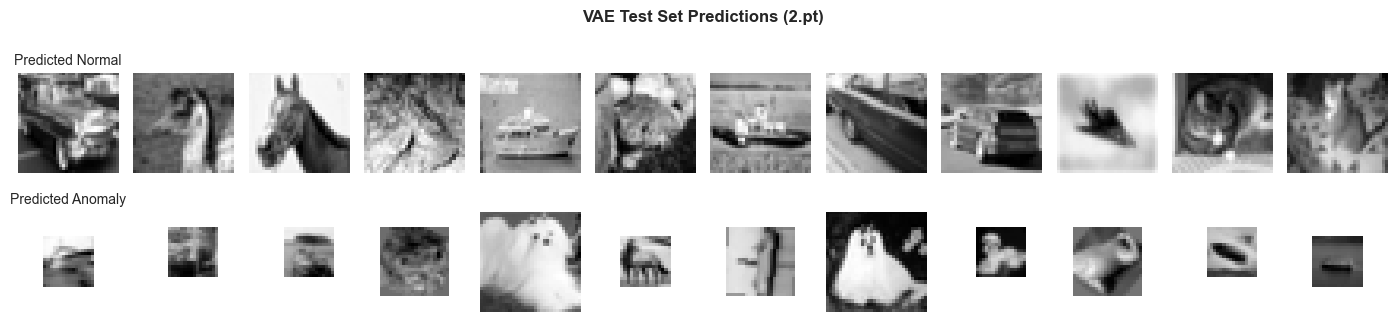

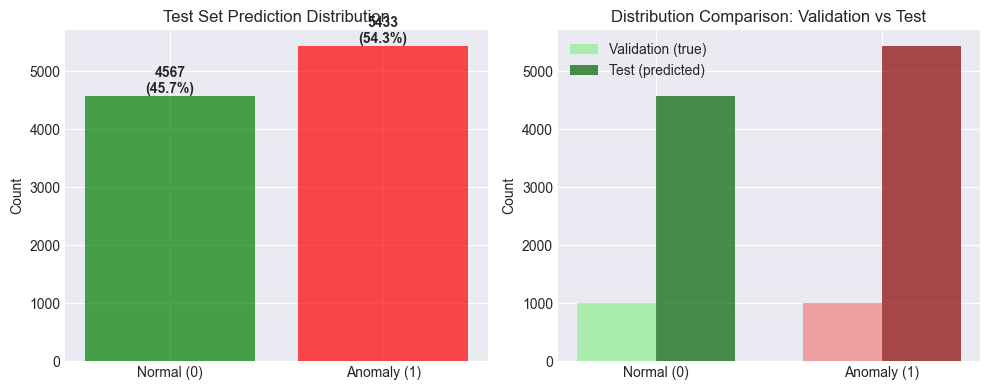

VAE Prediction Statistics:
Predicted Normal: 4567 (45.7%)
Predicted Anomaly: 5433 (54.3%)


In [7]:
# Load VAE predictions
predictions_2pt = torch.load(RESULTS_DIR / '2.pt', weights_only=False)
test_data_loaded, predictions_2pt = predictions_2pt[0:len(predictions_2pt)]

# Visualize VAE predictions
def visualize_vae_predictions(data, predictions, n_samples=12):
    """Visualize test samples split by predicted labels"""
    
    normal_indices = torch.where(predictions == 0)[0][:n_samples]
    anomaly_indices = torch.where(predictions == 1)[0][:n_samples]
    
    fig, axes = plt.subplots(2, n_samples, figsize=(14, 3.5))
    
    for i, idx in enumerate(normal_indices):
        img = data[idx].squeeze()
        axes[0, i].imshow(img, cmap='gray')
        axes[0, i].axis('off')
        if i == 0:
            axes[0, i].set_title('Predicted Normal', fontsize=10)
    
    for i, idx in enumerate(anomaly_indices):
        img = data[idx].squeeze()
        axes[1, i].imshow(img, cmap='gray')
        axes[1, i].axis('off')
        if i == 0:
            axes[1, i].set_title('Predicted Anomaly', fontsize=10)
    
    plt.suptitle('VAE Test Set Predictions (2.pt)', fontsize=12, fontweight='bold')
    plt.tight_layout()
    plt.show()

visualize_vae_predictions(test_data_loaded, predictions_2pt, n_samples=12)

# Distribution charts
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

labels = ['Normal (0)', 'Anomaly (1)']
counts = [(predictions_2pt == 0).sum().item(), (predictions_2pt == 1).sum().item()]
colors = ['green', 'red']

ax1.bar(labels, counts, color=colors, alpha=0.7)
ax1.set_ylabel('Count')
ax1.set_title('Test Set Prediction Distribution')
for i, v in enumerate(counts):
    ax1.text(i, v + 50, f'{v}\n({v/len(predictions_2pt):.1%})', 
             ha='center', fontweight='bold')

# Compare with validation
val_data, val_targets = ad_val[0:len(ad_val)]
val_counts = [(val_targets == 0).sum().item(), (val_targets == 1).sum().item()]
test_counts = counts

x = np.arange(len(labels))
width = 0.35

ax2.bar(x - width/2, val_counts, width, label='Validation (true)', alpha=0.7, color=['lightgreen', 'lightcoral'])
ax2.bar(x + width/2, test_counts, width, label='Test (predicted)', alpha=0.7, color=['darkgreen', 'darkred'])
ax2.set_ylabel('Count')
ax2.set_title('Distribution Comparison: Validation vs Test')
ax2.set_xticks(x)
ax2.set_xticklabels(labels)
ax2.legend()

plt.tight_layout()
plt.show()

print("VAE Prediction Statistics:")
print(f"Predicted Normal: {counts[0]} ({counts[0]/len(predictions_2pt):.1%})")
print(f"Predicted Anomaly: {counts[1]} ({counts[1]/len(predictions_2pt):.1%})")

## Alternative model for comparative analysis: Standard Autoencoder.

In [8]:
class SimpleAutoencoder(nn.Module):
    def __init__(self, input_dim=1024):
        super(SimpleAutoencoder, self).__init__()
        
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 16)
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(16, 128),
            nn.ReLU(),
            nn.Linear(128, input_dim),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

# 1. Train model
# Training data preparation and normalisation
train_data, train_labels = normal_dataset[0:len(normal_dataset)]
train_data_flat = train_data.view(train_data.size(0), -1).float()

# Normalise training data
train_data_normalised = []
for i in range(len(train_data_flat)):
    sample = train_data_flat[i]
    sample_norm = (sample - sample.min()) / (sample.max() - sample.min() + 1e-8)
    train_data_normalised.append(sample_norm)
train_data_flat = torch.stack(train_data_normalised)

# Create training DataLoader
train_dataset = TensorDataset(train_data_flat)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)

print(f"Training on {len(train_data_flat)} samples from dataset.pt")
print("Architecture: 1024 -> 128 -> 16 -> 128 -> 1024")

# Initialise model
simple_ae = SimpleAutoencoder(input_dim=1024).to(DEVICE)
criterion = nn.MSELoss()
optimizer = optim.Adam(simple_ae.parameters(), lr=0.002)

# Training with early stopping
num_epochs = 100
best_train_loss = float('inf')
patience_counter = 0
patience = 10

for epoch in range(num_epochs):
    simple_ae.train()
    epoch_loss = 0
    
    for batch_data in train_loader:
        data = batch_data[0].to(DEVICE)
        
        output = simple_ae(data)
        loss = criterion(output, data)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
    
    avg_loss = epoch_loss / len(train_loader)
    
    # Early stopping check
    if avg_loss < best_train_loss:
        best_train_loss = avg_loss
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break
    
    if (epoch + 1) % 20 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.6f}')

# 2. Validation
# Load validation data
val_data, val_targets = ad_val[0:len(ad_val)]
val_data_flat = val_data.view(val_data.size(0), -1).float()

# Normalise validation data
val_data_normalized = []
for i in range(len(val_data_flat)):
    sample = val_data_flat[i]
    sample_norm = (sample - sample.min()) / (sample.max() - sample.min() + 1e-8)
    val_data_normalized.append(sample_norm)
val_data_flat = torch.stack(val_data_normalized)

# Create validation DataLoader
val_dataset = TensorDataset(val_data_flat)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)

# Calculate reconstruction errors on validation set
print("Calculating reconstruction errors on validation set...")
simple_ae.eval()
val_errors = []

with torch.no_grad():
    for batch_data in val_loader:
        data = batch_data[0].to(DEVICE)
        output = simple_ae(data)
        
        # Per-sample MSE
        batch_errors = torch.mean((data - output) ** 2, dim=1)
        val_errors.extend(batch_errors.cpu().numpy())

val_errors = np.array(val_errors)

# Separate normal and anomaly errors
normal_mask = (val_targets == 0)
normal_errors = val_errors[normal_mask]
anomaly_errors = val_errors[~normal_mask]

print(f"Normal error range: [{normal_errors.min():.6f}, {normal_errors.max():.6f}]")
print(f"Anomaly error range: [{anomaly_errors.min():.6f}, {anomaly_errors.max():.6f}]")
print(f"Normal mean: {normal_errors.mean():.6f}, std: {normal_errors.std():.6f}")
print(f"Anomaly mean: {anomaly_errors.mean():.6f}, std: {anomaly_errors.std():.6f}")

# Test multiple percentiles for threshold
percentiles_to_test = [80, 85, 90, 92, 94, 95, 96, 97, 98, 99]

print("\nTesting percentile-based thresholds:")
best_f1 = 0
best_threshold = 0
best_percentile = 0

for p in percentiles_to_test:
    threshold = np.percentile(normal_errors, p)
    predictions = (val_errors > threshold).astype(int)
    
    acc = accuracy_score(val_targets.numpy(), predictions)
    f1 = f1_score(val_targets.numpy(), predictions)
    prec = precision_score(val_targets.numpy(), predictions) if predictions.sum() > 0 else 0
    rec = recall_score(val_targets.numpy(), predictions)
    
    print(f"  {p}%: thresh={threshold:.4f}, Acc={acc:.3f}, F1={f1:.3f}, Prec={prec:.3f}, Rec={rec:.3f}")
    
    if f1 > best_f1:
        best_f1 = f1
        best_threshold = threshold
        best_percentile = p

print(f"\nBest percentile: {best_percentile}% (threshold={best_threshold:.6f})")

# Final validation performance with best threshold
val_predictions = (val_errors > best_threshold).astype(int)

ae_acc = accuracy_score(val_targets.numpy(), val_predictions)
ae_f1 = f1_score(val_targets.numpy(), val_predictions)
ae_prec = precision_score(val_targets.numpy(), val_predictions)
ae_rec = recall_score(val_targets.numpy(), val_predictions)
ae_auroc = roc_auc_score(val_targets.numpy(), val_errors)
ae_auprc = average_precision_score(val_targets.numpy(), val_errors)

print("Validation performance:")
print(f"  Accuracy:  {ae_acc:.4f}")
print(f"  F1-Score:  {ae_f1:.4f}")
print(f"  Precision: {ae_prec:.4f}")
print(f"  Recall:    {ae_rec:.4f}")
print(f"  AUROC:     {ae_auroc:.4f}")
print(f"  AUPRC:     {ae_auprc:.4f}")

Training on 10000 samples from dataset.pt
Architecture: 1024 -> 128 -> 16 -> 128 -> 1024
Epoch [20/100], Loss: 0.019861
Epoch [40/100], Loss: 0.019610
Epoch [60/100], Loss: 0.019464
Epoch [80/100], Loss: 0.019343
Early stopping at epoch 94
Calculating reconstruction errors on validation set...
Normal error range: [0.004826, 0.054879]
Anomaly error range: [0.006678, 0.056078]
Normal mean: 0.019462, std: 0.007619
Anomaly mean: 0.024023, std: 0.007739

Testing percentile-based thresholds:
  80%: thresh=0.0248, Acc=0.610, F1=0.519, Prec=0.677, Rec=0.420
  85%: thresh=0.0271, Acc=0.579, F1=0.422, Prec=0.672, Rec=0.308
  90%: thresh=0.0298, Acc=0.550, F1=0.309, Prec=0.668, Rec=0.201
  92%: thresh=0.0312, Acc=0.540, F1=0.258, Prec=0.667, Rec=0.160
  94%: thresh=0.0333, Acc=0.525, F1=0.190, Prec=0.649, Rec=0.111
  95%: thresh=0.0339, Acc=0.525, F1=0.174, Prec=0.667, Rec=0.100
  96%: thresh=0.0352, Acc=0.520, F1=0.143, Prec=0.667, Rec=0.080
  97%: thresh=0.0364, Acc=0.517, F1=0.119, Prec=0.684,

## Alternative model for comparative analysis: Denoising Autoencoder.

In [9]:
class DAE(nn.Module):
    def __init__(self, input_dim=1024):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.ReLU(),
            nn.BatchNorm1d(512),
            nn.Dropout(0.3),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Linear(128, 32)
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(32, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Linear(128, 512),
            nn.ReLU(),
            nn.Linear(512, input_dim),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

# 1. Train model
# Load and prepare training data
train_data, train_labels = normal_dataset[0:len(normal_dataset)]
train_data_flat = train_data.view(train_data.size(0), -1).float()

# Normalise training data
train_data_normalized = []
for i in range(len(train_data_flat)):
    sample = train_data_flat[i]
    sample_norm = (sample - sample.min()) / (sample.max() - sample.min() + 1e-8)
    train_data_normalized.append(sample_norm)
train_data_flat = torch.stack(train_data_normalized)

# Create DataLoader
train_dataset = TensorDataset(train_data_flat)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)

print(f"Training samples: {len(train_data_flat)} from dataset.pt")

# Initialize model
dae = DAE(input_dim=1024).to(DEVICE)
criterion = nn.MSELoss()
optimizer = optim.Adam(dae.parameters(), lr=0.001)

# Training parameters
noise_factor = 0.25
num_epochs = 50

# Training loop
for epoch in range(num_epochs):
    dae.train()
    epoch_loss = 0
    
    for batch_data in train_loader:
        clean_data = batch_data[0].to(DEVICE)
        
        # Add noise corruption
        corrupted = clean_data + noise_factor * torch.randn_like(clean_data)
        corrupted = torch.clamp(corrupted, 0., 1.)
        
        # Reconstruct clean from corrupted
        output = dae(corrupted)
        loss = criterion(output, clean_data)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
    
    if (epoch + 1) % 10 == 0:
        avg_loss = epoch_loss / len(train_loader)
        print(f'Epoch {epoch+1}, Loss: {avg_loss:.6f}')

# 2. Validation
# Load validation data
val_data, val_targets = ad_val[0:len(ad_val)]
val_data_flat = val_data.view(val_data.size(0), -1).float()

# Normalize validation data
val_data_normalized = []
for i in range(len(val_data_flat)):
    sample = val_data_flat[i]
    sample_norm = (sample - sample.min()) / (sample.max() - sample.min() + 1e-8)
    val_data_normalized.append(sample_norm)
val_data_flat = torch.stack(val_data_normalized)

# Calculate reconstruction errors (NO noise during evaluation)
dae.eval()
val_errors = []

with torch.no_grad():
    for i in range(0, len(val_data_flat), 128):
        batch = val_data_flat[i:i+128].to(DEVICE)
        output = dae(batch)  # Clean input
        batch_errors = torch.mean((batch - output) ** 2, dim=1)
        val_errors.extend(batch_errors.cpu().numpy())

val_errors = np.array(val_errors)

# Analyze error distributions
normal_mask = (val_targets == 0)
normal_errors = val_errors[normal_mask]
anomaly_errors = val_errors[~normal_mask]

print(f"Normal errors - Mean: {normal_errors.mean():.6f}, Std: {normal_errors.std():.6f}")
print(f"Anomaly errors - Mean: {anomaly_errors.mean():.6f}, Std: {anomaly_errors.std():.6f}")
print(f"Separation: {(anomaly_errors.mean() - normal_errors.mean())/normal_errors.std():.2f} std")

# Find optimal threshold
percentiles = [60, 65, 70, 75, 80, 85, 90, 92, 94, 95, 96, 97, 98, 99]
best_f1 = 0
best_threshold = 0
best_percentile = 0

print("\nThreshold optimization:")
for p in percentiles:
    threshold = np.percentile(normal_errors, p)
    predictions = (val_errors > threshold).astype(int)
    f1 = f1_score(val_targets.numpy(), predictions)
    
    if f1 > best_f1:
        best_f1 = f1
        best_threshold = threshold
        best_percentile = p
    
    print(f"  {p}%: F1={f1:.3f}")

print(f"\nBest threshold: {best_threshold:.6f} (percentile {best_percentile}%)")

# Final validation metrics
val_predictions = (val_errors > best_threshold).astype(int)

dae_acc = accuracy_score(val_targets.numpy(), val_predictions)
dae_f1 = f1_score(val_targets.numpy(), val_predictions)
dae_prec = precision_score(val_targets.numpy(), val_predictions)
dae_rec = recall_score(val_targets.numpy(), val_predictions)
dae_auroc = roc_auc_score(val_targets.numpy(), val_errors)
dae_auprc = average_precision_score(val_targets.numpy(), val_errors)

print("\nValidation Performance:")
print(f"  Accuracy:  {dae_acc:.4f}")
print(f"  F1-Score:  {dae_f1:.4f}")
print(f"  Precision: {dae_prec:.4f}")
print(f"  Recall:    {dae_rec:.4f}")
print(f"  AUROC:     {dae_auroc:.4f}")
print(f"  AUPRC:     {dae_auprc:.4f}")

Training samples: 10000 from dataset.pt
Epoch 10, Loss: 0.021853
Epoch 20, Loss: 0.019815
Epoch 30, Loss: 0.018897
Epoch 40, Loss: 0.018230
Epoch 50, Loss: 0.017975
Normal errors - Mean: 0.015007, Std: 0.005204
Anomaly errors - Mean: 0.016977, Std: 0.005318
Separation: 0.38 std

Threshold optimization:
  60%: F1=0.587
  65%: F1=0.556
  70%: F1=0.529
  75%: F1=0.474
  80%: F1=0.431
  85%: F1=0.348
  90%: F1=0.261
  92%: F1=0.191
  94%: F1=0.160
  95%: F1=0.133
  96%: F1=0.114
  97%: F1=0.087
  98%: F1=0.066
  99%: F1=0.037

Best threshold: 0.015570 (percentile 60%)

Validation Performance:
  Accuracy:  0.5905
  F1-Score:  0.5866
  Precision: 0.5923
  Recall:    0.5810
  AUROC:     0.6130
  AUPRC:     0.5870


## **Out-of-Distribution (OOD) Detection: Mahalanobis**.

  Class 0: 1000 samples
  Class 1: 1000 samples
  Class 2: 1000 samples
  Class 3: 1000 samples
  Class 4: 1000 samples
  Class 5: 1000 samples
  Class 6: 1000 samples
  Class 7: 1000 samples
  Class 8: 1000 samples
  Class 9: 1000 samples

Validation samples: 5000

Initial AUROC: 0.9823

Validation performance:
AUROC:         0.9823
AUPRC:         0.9873
FPR@95%TPR:    0.0568
Accuracy:      0.9510
Precision:     0.9767
Recall:        0.9240
F1-Score:      0.9496
Optimal Threshold: 25.0665


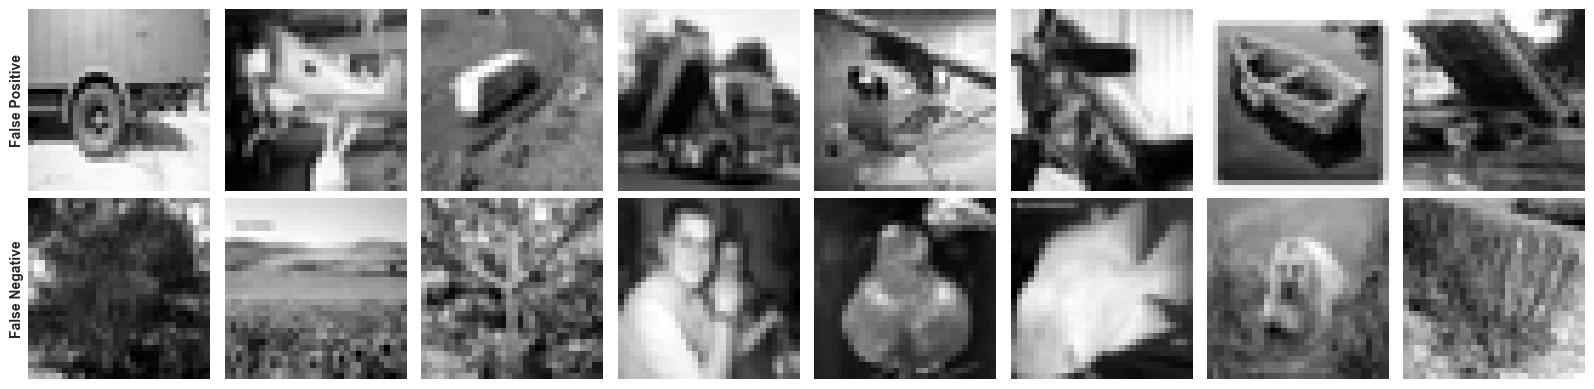


OOD Error Analysis:
False Positives: 55 (2.20% of ID)
False Negatives: 190 (7.60% of OOD)

Test predictions: OOD = 4733/10000 (47.3%)


In [10]:
class FeatureExtractor(nn.Module):
    def __init__(self, base_model):
        super().__init__()
        self.conv1 = base_model.model.conv1
        self.conv2 = base_model.model.conv2
        self.conv3 = base_model.model.conv3
        self.conv4 = base_model.model.conv4
        self.conv5 = base_model.model.conv5
        self.conv6 = base_model.model.conv6
        self.conv7 = base_model.model.conv7
        self.conv8 = base_model.model.conv8
        self.conv9 = base_model.model.conv9
        self.pool10 = base_model.model.pool10
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = x + self.conv5(self.conv4(x))
        x = self.conv6(x)
        x = self.conv7(x)
        x = x + self.conv9(self.conv8(x))
        x = self.pool10(x)
        return x.reshape(x.size(0), -1)

feature_extractor = FeatureExtractor(pretrained_model).to(DEVICE)
feature_extractor.eval()

train_data = normal_dataset

class_features = {i: [] for i in range(10)}

with torch.no_grad():
    for batch_idx, (batch_data, batch_labels) in enumerate(train_data):
        if batch_data.dim() == 3:
            batch_data = batch_data.unsqueeze(1)
        if batch_labels.dim() == 0:
            batch_labels = batch_labels.unsqueeze(0)
        
        batch_data = batch_data.to(DEVICE)
        features = feature_extractor(batch_data)
        
        for feat, label in zip(features, batch_labels):
            class_features[label.item()].append(feat.cpu())

# Compute class-specific Gaussian parameters
class_means = {}
class_cov_invs = {}

for c in range(10):
    features_tensor = torch.stack(class_features[c])
    class_means[c] = features_tensor.mean(dim=0)
    
    centered = features_tensor - class_means[c]
    cov = (centered.T @ centered) / (len(features_tensor) - 1)
    
    cov += torch.eye(cov.shape[0]) * 0.01
    class_cov_invs[c] = torch.linalg.inv(cov)
    print(f"  Class {c}: {len(class_features[c])} samples")

def compute_mahalanobis_distances(features):
    distances = []
    for feat in features:
        class_distances = []
        for c in range(10):
            diff = feat - class_means[c]
            dist = torch.sqrt((diff @ class_cov_invs[c] @ diff).clamp(min=0))
            class_distances.append(dist.item())
        distances.append(min(class_distances))
    return torch.tensor(distances)

val_data = ood_val
print(f"\nValidation samples: {len(val_data)}")

val_features_list = []
val_labels = []

with torch.no_grad():
    for batch_data, batch_labels in val_data:
        if batch_data.dim() == 3:
            batch_data = batch_data.unsqueeze(1)
        if batch_labels.dim() == 0:
            batch_labels = batch_labels.unsqueeze(0)
        
        batch_data = batch_data.to(DEVICE)
        features = feature_extractor(batch_data)
        val_features_list.append(features.cpu())
        val_labels.extend(batch_labels.tolist())

val_features = torch.cat(val_features_list)
val_labels = torch.tensor(val_labels)
val_distances = compute_mahalanobis_distances(val_features)

# Check AUROC direction and flip BEFORE computing threshold
auroc_test = roc_auc_score(val_labels.numpy(), val_distances.numpy())
print(f"\nInitial AUROC: {auroc_test:.4f}")

if auroc_test < 0.5:
    print("Distance direction inverted - flipping distances")
    val_distances = -val_distances
    auroc_test = roc_auc_score(val_labels.numpy(), val_distances.numpy())
    print(f"Corrected AUROC: {auroc_test:.4f}")

# Compute threshold with corrected distances
fpr, tpr, thresholds = roc_curve(val_labels.numpy(), val_distances.numpy())
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
val_predictions = (val_distances > optimal_threshold).long()

auroc = roc_auc_score(val_labels.numpy(), val_distances.numpy())
precision_vals, recall_vals, _ = precision_recall_curve(val_labels.numpy(), val_distances.numpy())
auprc = auc(recall_vals, precision_vals)

accuracy = (val_predictions == val_labels).float().mean().item()
tp = ((val_predictions == 1) & (val_labels == 1)).sum().item()
fp = ((val_predictions == 1) & (val_labels == 0)).sum().item()
tn = ((val_predictions == 0) & (val_labels == 0)).sum().item()
fn = ((val_predictions == 0) & (val_labels == 1)).sum().item()

precision = tp / (tp + fp) if (tp + fp) > 0 else 0
recall = tp / (tp + fn) if (tp + fn) > 0 else 0
f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
fpr_val = fp / (fp + tn) if (fp + tn) > 0 else 0

tpr_95_idx = np.where(tpr >= 0.95)[0]
fpr_at_95_tpr = fpr[tpr_95_idx[0]] if len(tpr_95_idx) > 0 else 1.0

print("\nValidation performance:")
print(f"AUROC:         {auroc:.4f}")
print(f"AUPRC:         {auprc:.4f}")
print(f"FPR@95%TPR:    {fpr_at_95_tpr:.4f}")
print(f"Accuracy:      {accuracy:.4f}")
print(f"Precision:     {precision:.4f}")
print(f"Recall:        {recall:.4f}")
print(f"F1-Score:      {f1:.4f}")
print(f"Optimal Threshold: {optimal_threshold:.4f}")

# Extract validation images for visualisation
val_images_list = []
with torch.no_grad():
    for batch_data, batch_labels in ood_val:
        if batch_data.dim() == 3:
            batch_data = batch_data.unsqueeze(1)
        val_images_list.append(batch_data.cpu())
val_images = torch.cat(val_images_list)

# OOD Error Visualization
fp_mask = (val_predictions == 1) & (val_labels == 0)
fn_mask = (val_predictions == 0) & (val_labels == 1)

fp_indices = np.where(fp_mask.numpy())[0]
fn_indices = np.where(fn_mask.numpy())[0]

n_display = 8
fig, axes = plt.subplots(2, n_display, figsize=(16, 4))

for i in range(min(n_display, len(fp_indices))):
    axes[0, i].imshow(val_images[fp_indices[i]].squeeze(), cmap='gray')
    axes[0, i].axis('off')

for i in range(min(n_display, len(fn_indices))):
    axes[1, i].imshow(val_images[fn_indices[i]].squeeze(), cmap='gray')
    axes[1, i].axis('off')

axes[0, 0].text(-0.1, 0.5, 'False Positive\n', 
                transform=axes[0, 0].transAxes, rotation=90, va='center', 
                fontsize=10, weight='bold')
axes[1, 0].text(-0.1, 0.5, 'False Negative\n', 
                transform=axes[1, 0].transAxes, rotation=90, va='center', 
                fontsize=10, weight='bold')

plt.tight_layout()
plt.savefig('ood_error_examples.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\nOOD Error Analysis:")
print(f"False Positives: {fp_mask.sum().item()} ({100*fp_mask.sum().item()/(val_labels==0).sum().item():.2f}% of ID)")
print(f"False Negatives: {fn_mask.sum().item()} ({100*fn_mask.sum().item()/(val_labels==1).sum().item():.2f}% of OOD)")

# Save the flip flag so Red Team knows whether to flip
checkpoint = {
    'class_means': class_means,
    'class_cov_invs': class_cov_invs,
    'optimal_threshold': optimal_threshold,
    'auroc_test': auroc_test,
    'flip_distances': auroc_test < 0.5  # Add this flag
}
torch.save(checkpoint, DATA_DIR / 'mahalanobis_ood_detector.pt')

# Test set predictions
test_images_list = []
test_features_list = []

with torch.no_grad():
    for item in ood_test:
        batch_data = item[0] if isinstance(item, tuple) else item
        if batch_data.dim() == 3:
            batch_data = batch_data.unsqueeze(1)
        
        test_images_list.append(batch_data.cpu())
        batch_data = batch_data.to(DEVICE)
        features = feature_extractor(batch_data)
        test_features_list.append(features.cpu())

test_images = torch.cat(test_images_list)
test_features = torch.cat(test_features_list)
test_distances = compute_mahalanobis_distances(test_features)

# Apply same flip logic as validation
if auroc_test < 0.5:
    test_distances = -test_distances

test_predictions = (test_distances > optimal_threshold).long()

test_dataset = TensorDataset(test_images, test_predictions)
torch.save(test_dataset, RESULTS_DIR / "3.pt")

print(f"\nTest predictions: OOD = {test_predictions.sum().item()}/{len(test_predictions)} ({100*test_predictions.sum().item()/len(test_predictions):.1f}%)")

## Post-hoc analysis and Mahalanobis OOD detection prediction visualisation. 

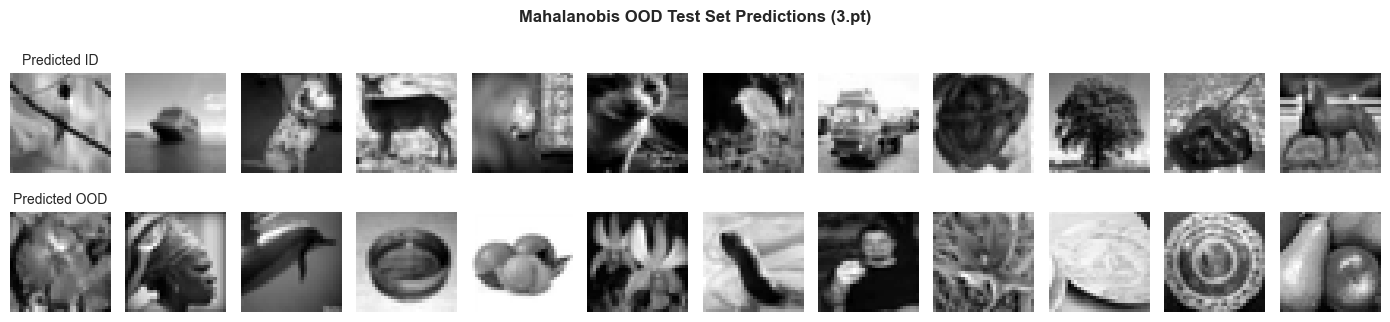

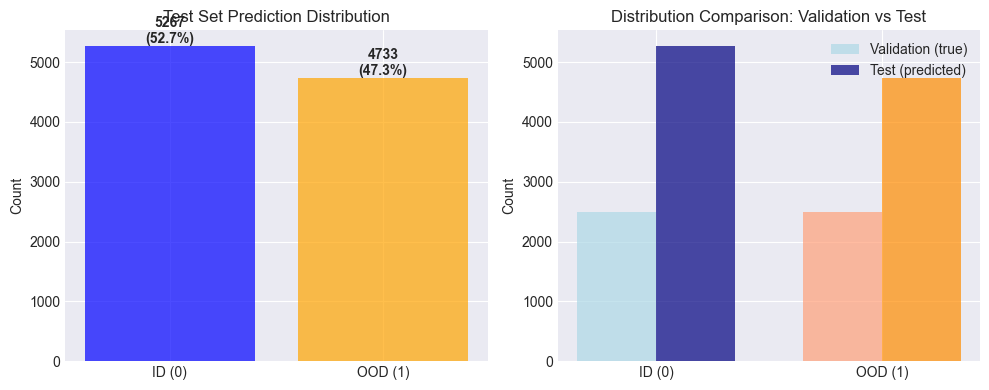

OOD Detection Statistics:
Predicted ID: 5267 (52.7%)
Predicted OOD: 4733 (47.3%)


In [11]:
# Load OOD predictions
predictions_3pt = torch.load(RESULTS_DIR / '3.pt', weights_only=False)
test_data_loaded_ood, predictions_3pt = predictions_3pt[0:len(predictions_3pt)]

# Visualize OOD predictions
def visualize_ood_predictions(data, predictions, n_samples=12):
    """Visualize test samples split by predicted labels"""
    
    id_indices = torch.where(predictions == 0)[0][:n_samples]
    ood_indices = torch.where(predictions == 1)[0][:n_samples]
    
    fig, axes = plt.subplots(2, n_samples, figsize=(14, 3.5))
    
    for i, idx in enumerate(id_indices):
        img = data[idx].squeeze()
        axes[0, i].imshow(img, cmap='gray')
        axes[0, i].axis('off')
        if i == 0:
            axes[0, i].set_title('Predicted ID', fontsize=10)
    
    for i, idx in enumerate(ood_indices):
        img = data[idx].squeeze()
        axes[1, i].imshow(img, cmap='gray')
        axes[1, i].axis('off')
        if i == 0:
            axes[1, i].set_title('Predicted OOD', fontsize=10)
    
    plt.suptitle('Mahalanobis OOD Test Set Predictions (3.pt)', fontsize=12, fontweight='bold')
    plt.tight_layout()
    plt.show()

visualize_ood_predictions(test_data_loaded_ood, predictions_3pt, n_samples=12)

# Distribution charts
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

labels = ['ID (0)', 'OOD (1)']
counts = [(predictions_3pt == 0).sum().item(), (predictions_3pt == 1).sum().item()]
colors = ['blue', 'orange']

ax1.bar(labels, counts, color=colors, alpha=0.7)
ax1.set_ylabel('Count')
ax1.set_title('Test Set Prediction Distribution')
for i, v in enumerate(counts):
    ax1.text(i, v + 50, f'{v}\n({v/len(predictions_3pt):.1%})', 
             ha='center', fontweight='bold')

# Compare with OOD validation
ood_val_data, ood_val_targets = ood_val[0:len(ood_val)]
ood_val_counts = [(ood_val_targets == 0).sum().item(), (ood_val_targets == 1).sum().item()]
test_counts = counts

x = np.arange(len(labels))
width = 0.35

ax2.bar(x - width/2, ood_val_counts, width, label='Validation (true)', alpha=0.7, color=['lightblue', 'lightsalmon'])
ax2.bar(x + width/2, test_counts, width, label='Test (predicted)', alpha=0.7, color=['navy', 'darkorange'])
ax2.set_ylabel('Count')
ax2.set_title('Distribution Comparison: Validation vs Test')
ax2.set_xticks(x)
ax2.set_xticklabels(labels)
ax2.legend()

plt.tight_layout()
plt.show()

print("OOD Detection Statistics:")
print(f"Predicted ID: {counts[0]} ({counts[0]/len(predictions_3pt):.1%})")
print(f"Predicted OOD: {counts[1]} ({counts[1]/len(predictions_3pt):.1%})")

## OOD Detectors: Comparative analysis.

In [13]:
# Reuse the Mahalanobis scoring function
def compute_mahalanobis_scores(features):
    scores = []
    for feat in features:
        distances = []
        for c in range(10):
            diff = feat - class_means[c]
            dist = torch.sqrt((diff @ class_cov_invs[c] @ diff).clamp(min=0))
            distances.append(dist.item())
        scores.append(min(distances))
    return torch.tensor(scores)

def compute_msp_scores(images):
    """Higher scores = more likely ID"""
    scores = []
    with torch.no_grad():
        for i in range(0, len(images), 32):  # Batch processing
            batch = images[i:i+32]
            if batch.dim() == 3:
                batch = batch.unsqueeze(1)
            batch = batch.to(DEVICE)
            logits = pretrained_model(batch)
            probs = F.softmax(logits, dim=1)
            max_probs, _ = probs.max(dim=1)
            scores.extend(max_probs.cpu().tolist())
    return torch.tensor(scores)

# Load validation data
val_images_list = []
val_features_list = []
val_labels = []

with torch.no_grad():
    for batch_data, batch_labels in ood_val:
        if batch_data.dim() == 3:
            batch_data = batch_data.unsqueeze(1)
        if batch_labels.dim() == 0:
            batch_labels = batch_labels.unsqueeze(0)
        
        val_images_list.append(batch_data)
        
        batch_data = batch_data.to(DEVICE)
        features = feature_extractor(batch_data)
        val_features_list.append(features.cpu())
        val_labels.extend(batch_labels.tolist())

val_images = torch.cat(val_images_list)
val_features = torch.cat(val_features_list)
val_labels = torch.tensor(val_labels)

# Compute scores for all methods
maha_scores = compute_mahalanobis_scores(val_features)
msp_scores = compute_msp_scores(val_images)

# Evaluation function
def evaluate_method(scores, labels, method_name):
    # Check if scores need flipping
    auroc_test = roc_auc_score(labels.numpy(), scores.numpy())
    if auroc_test < 0.5:
        scores = -scores
        auroc_test = 1 - auroc_test
    
    # Compute metrics
    fpr, tpr, thresholds = roc_curve(labels.numpy(), scores.numpy())
    optimal_idx = np.argmax(tpr - fpr)
    optimal_threshold = thresholds[optimal_idx]
    
    predictions = (scores > optimal_threshold).long()
    
    auroc = roc_auc_score(labels.numpy(), scores.numpy())
    precision_vals, recall_vals, _ = precision_recall_curve(labels.numpy(), scores.numpy())
    auprc = auc(recall_vals, precision_vals)
    
    accuracy = (predictions == labels).float().mean().item()
    
    cm = confusion_matrix(labels.numpy(), predictions.numpy())
    tn, fp, fn, tp = cm.ravel()
    
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
    
    # FPR at 95% TPR
    tpr_95_idx = np.where(tpr >= 0.95)[0]
    fpr_at_95_tpr = fpr[tpr_95_idx[0]] if len(tpr_95_idx) > 0 else 1.0
    
    return {
        'method': method_name,
        'scores': scores,
        'threshold': optimal_threshold,
        'auroc': auroc,
        'auprc': auprc,
        'fpr_95': fpr_at_95_tpr,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'fpr_curve': fpr,
        'tpr_curve': tpr,
    }

# Evaluate individual methods
results = {}
results['Mahalanobis'] = evaluate_method(maha_scores, val_labels, 'Mahalanobis')
results['MSP'] = evaluate_method(msp_scores, val_labels, 'MSP')

# Print results table
print("Validation performance: ")
print(f"{'Method':<12} {'AUROC':<7} {'AUPRC':<7} {'FPR@95':<8} {'Acc':<7} {'Prec':<7} {'Rec':<7} {'F1':<7}")
print("-" * 70)

for method_name in ['Mahalanobis', 'MSP']:
    r = results[method_name]
    print(f"{method_name:<12} {r['auroc']:.4f}  {r['auprc']:.4f}  {r['fpr_95']:.4f}   "
          f"{r['accuracy']:.4f}  {r['precision']:.4f}  {r['recall']:.4f}  {r['f1']:.4f}")

# Select best method
best_method = max(results.items(), key=lambda x: x[1]['auroc'])
best_name = best_method[0]
best_result = best_method[1]

print(f"Best method: {best_name} (AUROC = {best_result['auroc']:.4f})")

Validation performance: 
Method       AUROC   AUPRC   FPR@95   Acc     Prec    Rec     F1     
----------------------------------------------------------------------
Mahalanobis  0.9823  0.9873  0.0568   0.9510  0.9767  0.9240  0.9496
MSP          0.8714  0.8486  0.4680   0.8210  0.8129  0.8340  0.8233
Best method: Mahalanobis (AUROC = 0.9823)


Save models for Red Team testing.

In [14]:
# 1. Save OCSVM (Shallow Anomaly Detector)
joblib.dump(ocsvm_final, DATA_DIR/'ocsvm_anomaly_detector.pkl')

print("Saved: ocsvm_anomaly_detector.pkl")

# 2. Save Autoencoder (Deep Anomaly Detector)
torch.save({
    'model_state_dict': vae.state_dict(),
    'threshold': best_threshold,  # Save the threshold too!
    'input_dim': 1024,  # Save architecture info
    'hidden_dim': 128
}, DATA_DIR/'vae_anomaly_detector.pt')
print("Saved: vae_anomaly_detector.pt")

# 3. Save Mahalanobis OOD Detector parameters

mahalanobis_checkpoint = {
    'class_means': {c: class_means[c].cpu() for c in range(10)},
    'class_cov_invs': {c: class_cov_invs[c].cpu() for c in range(10)},
    'optimal_threshold': optimal_threshold,
    'auroc_test': auroc_test,  # To know if we need to negate distances
    'feature_dim': class_means[0].shape[0],  # Feature dimension (512)
    'validation_auroc': auroc,
    'validation_accuracy': accuracy}

torch.save(mahalanobis_checkpoint, DATA_DIR / 'mahalanobis_ood_detector.pt')
print("Saved: mahalanobis_ood_detector.pt")

print(f"Saved into data/ folder:\n\
    - ocsvm_anomaly_detector.pkl (OCSVM anomaly detector)\n\
    - vae_anomaly_detector.pt (VAE anomaly detector)\n\
    - mahalanobis_ood_detector.pt (Mahalanobis OOD detector)")

Saved: ocsvm_anomaly_detector.pkl
Saved: vae_anomaly_detector.pt
Saved: mahalanobis_ood_detector.pt
Saved into data/ folder:
    - ocsvm_anomaly_detector.pkl (OCSVM anomaly detector)
    - vae_anomaly_detector.pt (VAE anomaly detector)
    - mahalanobis_ood_detector.pt (Mahalanobis OOD detector)
